<a href="https://colab.research.google.com/github/ChristianAgyapong/Medgemma/blob/main/Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

christianagyapong1_my_dataset_path = kagglehub.dataset_download('christianagyapong1/my-dataset')

print('Data source import complete.')


In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")


In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-eh2bnsdl/unsloth_5b71cd18227442d4adbfa31d0a4c5b42
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-eh2bnsdl/unsloth_5b71cd18227442d4adbfa31d0a4c5b42
  Resolved https://github.com/unslothai/unsloth.git to commit 872e191494104d177d854a2e2b430a03a193d4e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [ ]:
from unsloth import FastVisionModel
import torch


model_id = "google/medgemma-4b-it"


model, tokenizer = FastVisionModel.from_pretrained(
    model_id,
    load_in_4bit=True,
    use_gradient_checkpointing=True,
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-11-24 10:17:05.567590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763979425.590250    1529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763979425.597136    1529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers was not installed correctly.
Please install xformers separately first.
Then confirm if it's correctly installed by running:
python -m xformers.info

Longer error message:
xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu128 with CUDA 1208 (you have 2.6.0+cu124)
    Python  3.10.19 (you have 3.11.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Gemma3 patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.co

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_layers=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
    target_modules="all-linear"
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [ ]:
from datasets import load_dataset

data_dir = "/kaggle/input/my-dataset/dataset/Eczema (EC)"

dataset_dict = load_dataset("imagefolder", data_dir=data_dir, split="train")
dataset_dict

Resolving data files:   0%|          | 0/466 [00:00<?, ?it/s]

Dataset({
    features: ['image'],
    num_rows: 466
})

In [ ]:
train_size = 0.8
validation_size = 0.2


from datasets import DatasetDict
data_split = dataset_dict.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=39,
)


val_size = 0.3
test_size = 0.7
temp_split = data_split['test'].train_test_split(
    train_size=test_size,
    test_size=val_size,
    shuffle=True,
    seed=14,
)

data = {
    'train': data_split['train'],
    'validation': temp_split['train'],
    'test': temp_split['test']
}


data = DatasetDict({
    'train': data_split['train'],
    'validation': temp_split['test'],
    'test': temp_split['train'],
})

# Rename the 'test' split to 'validation'
#data["validation"] = data.pop("test")

# Display dataset details
print(data)

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 372
    })
    validation: Dataset({
        features: ['image'],
        num_rows: 29
    })
    test: Dataset({
        features: ['image'],
        num_rows: 65
    })
})


In [ ]:
# write a function to create a caption columns
# This dermatology image shows an eczema, fungal, scabies rash on the a patient skin.

def add_caption(example):
    captions = {
        'Eczema': 'eczema',    #'An image showing skin affected by eczema, characterized by dry, itchy, or inflammed patches.',
        #'fungal': fungal''An image showing a fungal skin infection, often characterized by redness, discoloured areas, and scaling.',
        'Scabies': 'scabies'  #'An image showing a scabies infection on human skin, with red bumps or burror-like marks.'
    }

    label_names = example['label_names']
    label_name = label_names[example['label']]

    example['caption'] = captions.get(label_name, 'Image of a skin condition')
    return example



In [ ]:
data['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}

In [ ]:
# Check if the dataset has labels
if 'label' in data['train'].features:
    label_names = data['train'].features['label'].names
    dataset = data.map(lambda ex: {**ex, 'label_names':label_names})
    dataset = dataset.map(add_caption)
else:
    # If no labels exist, we need to create a simple caption
    # Since this is Eczema dataset, all images are eczema
    def add_simple_caption(example):
        example['caption'] = 'eczema'
        return example

    dataset = data.map(add_simple_caption)
    print("No labels found in dataset. Using default caption 'eczema' for all images.")

No labels found in dataset. Using default caption 'eczema' for all images.


In [ ]:
dataset['train'][0]['caption']

'eczema'

In [ ]:
dataset['train'][48]['caption']

'eczema'

In [ ]:
#instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"


def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            #{"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }

In [ ]:
converted_train_dataset = [convert_to_conversation(sample) for sample in dataset['train'].shuffle(seed=22)]
converted_eval_dataset = [convert_to_conversation(sample) for sample in dataset['validation'].shuffle(seed=22)]

In [ ]:
converted_train_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 'eczema'}]}]}

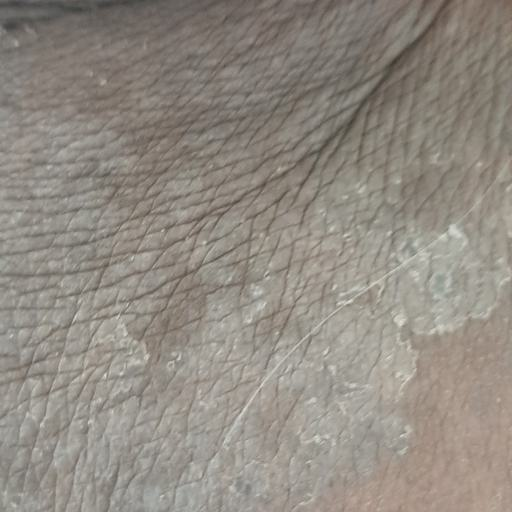

In [ ]:
dataset['train'][3]['image']

In [ ]:

import torch._dynamo
torch._dynamo.config.suppress_errors = True

FastVisionModel.for_inference(model) # Enable for inference!

image = dataset['train'][3]["image"]
instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

# Disable compilation for this specific call
with torch.no_grad():
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)

    # Use torch._dynamo.disable to prevent compilation errors
    with torch._dynamo.config.patch(suppress_errors=True):
        _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                           use_cache = True, temperature = 1.5, min_p = 0.1)

Based on the image, the most likely diagnosis is **Psoriasis**.

Here's why:

*   **Appearance:** The image shows raised, scaly patches with a well-defined border. This is a classic presentation of psoriasis. The scale is often silvery and can flake off.
*   **Distribution:** Psoriasis can occur on any part of the body, but it is commonly seen on the elbows, knees, scalp, and lower back. The presence of lesions on the skin in the image, particularly the elbows and knees, is suggestive.

Important considerations:

*   It is difficult to get a


In [ ]:
# Disable torch compile for older GPUs (P100 has CUDA Capability 6.0, Triton needs >= 7.0)
import torch._dynamo
torch._dynamo.config.suppress_errors = True

FastVisionModel.for_inference(model) # Enable for inference!

image = dataset['train'][3]["image"]
instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

# Disable compilation for this specific call
with torch.no_grad():
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)

    # Use torch._dynamo.disable to prevent compilation errors
    with torch._dynamo.config.patch(suppress_errors=True):
        _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                           use_cache = True, temperature = 1.5, min_p = 0.1)

Based on the image, the skin condition appears to be **Psoriasis**.

Here's why:

*   **Scaly, Raised Plaques:** The image shows areas of raised, thickened skin with a characteristic scaly appearance. This is a hallmark sign of psoriasis.
*   **Color Variations:** The patches appear to be uneven in color, with some areas being more red/inflammatory and others being lighter and more scaled.

It is important to note that I am only a text-based AI and cannot give a definitive diagnosis. A proper diagnosis requires a clinical examination, a patient history, and potentially additional testing by


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig


FastVisionModel.for_training(model)

args = SFTConfig(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        eval_strategy = 'steps',
        save_strategy = 'steps',
        eval_steps = 10,
        save_steps = 10,
        num_train_epochs = 12,
        learning_rate = 1.5e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "cosine_with_restarts",
        seed = 3407,
        output_dir = "medgemma-4b-unsloth-finetuned",
        report_to = "none",

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )

import random
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_train_dataset,
    eval_dataset = converted_eval_dataset,
    args=args
)

Unsloth: Switching to float32 training since model cannot work with float16


In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
5.178 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 372 | Num Epochs = 12 | Total steps = 288
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


Step,Training Loss,Validation Loss
10,3.928500,3.437647
20,0.719100,0.615252
30,0.001100,0.000941
40,0.000700,0.000683
50,0.000600,0.000611
60,0.000500,0.000496
70,0.000500,0.000473
80,0.000500,0.000465
90,0.000500,0.000466
100,0.000400,0.000464


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")


""""model.push_to_hub("wills004/lora_model", token = "...") # Online saving
tokenizer.push_to_hub("wills004/lora_model", token = "...") # Online saving"
"""

In [ ]:
del model
del tokenizer
torch.cuda.empty_cache()

In [ ]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset['validation'][30]["image"]
instruction = "You are an expert dermatolgist, analyze accurately and identify the type of skin condition in the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [ ]:
dataset

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score


"""model_name = " " # finetune so args.output_dir

model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    laod_in_4bit = True,)"""


model.eval() # evaluation mode
#dataset = load_dataset("imagefolder", data_dir="path/to/your/test_data")["test"]

# Get label names
label_names = dataset['train'].features["label"].names
print(label_names)



# Batch inference function
def batch_inference(model, tokenizer, dataset, batch_size=2):
    all_preds = []
    all_labels = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]
        if isinstance(batch, dict):
            for k in batch:
                batch[k] = [batch[k]]

        images = batch["image"]
        labels = batch["label"]

        #conversations should be a list of lists (each inner list = one conversation)
        conversations = [
            [
                {"role": "user", "content": [
                    {"type": "image", 'image': img},
                    #{"type": "text", "text": instruction}
                ]}
            ]
            for img in images
        ]

        # Apply chat template correctly
        input_texts = [
            tokenizer.apply_chat_template(conv, add_generation_prompt=True)
            for conv in conversations
        ]
        print(f"Batch images: {len(images)}, input_texts: {len(input_texts)}")

         #Tokenize both text and images
        inputs = tokenizer(
            images,
            input_texts,
            add_special_tokens=False,
            return_tensors="pt",
            padding=True
        ).to("cuda")

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=4,
                use_cache=True,
                temperature=0.0,
                #min_p=0.1
            )

        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_preds.extend(preds)
        all_labels.extend(labels)

    return all_preds, all_labels

predictions, true_labels = batch_inference(model, tokenizer, dataset['test'], batch_size=1)

# Convert textual predictions to label indices
pred_indices = []
for pred in predictions:
    matched = False
    for idx, label in enumerate(label_names):
        if label.lower() in pred.lower():
            pred_indices.append(idx)
            matched = True
            break
    if not matched:
        pred_indices.append(-1)  # Unknown prediction
# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")